# All Functions

In [3]:
# Super Trend Indicator

import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

# npNaN = np.nan

def calculate_supertrend(df, high_col='highprice', low_col='lowprice', close_col='closeprice', length=10, multiplier=3.0, offset=0, drop_columns=True, **kwargs):
    """
    Calculate the Supertrend indicator and merge it with the original DataFrame.
    
    Parameters:
        df (DataFrame): Original DataFrame containing the OHLC data.
        high_col (str): Name of the high price column. Default is 'highprice'.
        low_col (str): Name of the low price column. Default is 'lowprice'.
        close_col (str): Name of the close price column. Default is 'closeprice'.
        length (int): Lookback period for ATR calculation. Default is 10.
        multiplier (float): Multiplier for ATR. Default is 3.0.
        offset (int): Number of periods to shift the result. Default is 0.
        drop_columns (bool): Whether to drop intermediate columns. Default is True.
        **kwargs: Additional arguments for handling NaN values (e.g., fillna).
    
    Returns:
        DataFrame: The original DataFrame with Supertrend columns merged.
    """
    # Validate Arguments
    high = verify_series(df[high_col], length)
    low = verify_series(df[low_col], length)
    close = verify_series(df[close_col], length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return df

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    _props = f"_{length}_{multiplier}"
    supertrend_df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    # Apply offset if needed
    if offset != 0:
        supertrend_df = supertrend_df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        supertrend_df.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        supertrend_df.fillna(method=kwargs["fill_method"], inplace=True)

    # Merge with original DataFrame
    result_df = df.join(supertrend_df)

    # Drop unnecessary columns
    if drop_columns:
        result_df.drop(columns=[f"SUPERT{_props}", f"SUPERTd{_props}"], inplace=True)

    return result_df

In [4]:
# Ichimoku Cloud Indicator

import pandas as pd
import numpy as np

def compute_ichimoku_with_supertrend(supertrend_df, conversion_periods=9, base_periods=26, span_b_periods=52, displacement=26):
    """
    Compute Ichimoku Cloud components and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - conversion_periods (int): Period for the Conversion Line (Tenkan-sen). Default is 9.
    - base_periods (int): Period for the Base Line (Kijun-sen). Default is 26.
    - span_b_periods (int): Period for Leading Span B (Senkou Span B). Default is 52.
    - displacement (int): Displacement for Leading Spans. Default is 26.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed Ichimoku Cloud components.
    """
    # Helper to calculate the average of the highest high and lowest low
    def donchian(data, period):
        return (data['highprice'].rolling(window=period).max() + 
                data['lowprice'].rolling(window=period).min()) / 2

    # Compute Ichimoku Cloud components
    supertrend_df['conversion_line'] = donchian(supertrend_df, conversion_periods)
    supertrend_df['base_line'] = donchian(supertrend_df, base_periods)
    supertrend_df['leading_span_a'] = ((supertrend_df['conversion_line'] + supertrend_df['base_line']) / 2).shift(displacement)
    supertrend_df['leading_span_b'] = donchian(supertrend_df, span_b_periods).shift(displacement)
    supertrend_df['lagging_span'] = supertrend_df['closeprice'].shift(-displacement)
    
    # Drop unnecessary columns
    supertrend_df.drop(columns=['conversion_line', 'base_line', 'lagging_span'], inplace=True)
    
    return supertrend_df

In [ ]:
# Add MACD

import pandas as pd
import numpy as np

def compute_macd_with_supertrend(supertrend_df, fast_period=12, slow_period=26, signal_period=9):
    """
    Compute MACD and Signal Line and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - fast_period (int): Period for the fast EMA (12-period). Default is 12.
    - slow_period (int): Period for the slow EMA (26-period). Default is 26.
    - signal_period (int): Period for the Signal line (9-period). Default is 9.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed MACD components.
    """
    # Compute MACD Line (fast EMA - slow EMA)
    supertrend_df['macd_line'] = supertrend_df['closeprice'].ewm(span=fast_period, adjust=False).mean() - supertrend_df['closeprice'].ewm(span=slow_period, adjust=False).mean()
    
    # Compute Signal Line (9-period EMA of the MACD line)
    supertrend_df['signal_line'] = supertrend_df['macd_line'].ewm(span=signal_period, adjust=False).mean()
    
    # Compute Histogram (MACD Line - Signal Line)
    supertrend_df['histogram'] = supertrend_df['macd_line'] - supertrend_df['signal_line']
    
    # Return the DataFrame with MACD, Signal, and Histogram columns
    return supertrend_df

In [5]:
# Back Test Signaling

import numpy as np
import pandas as pd

def generate_backtest_trade_recap(df):
    # Step 1: Rename columns
    new_column_names = {
        'opentime': 'time',
        'openprice': 'open',
        'highprice': 'high',
        'lowprice': 'low',
        'closeprice': 'close',
        'SUPERTl_10_3.0': 'Up Trend',
        'SUPERTs_10_3.0': 'Down Trend',
        'leading_span_a': 'Leading Span A',
        'leading_span_b': 'Leading Span B',
    }
    df.rename(columns=new_column_names, inplace=True)

    # Add columns for further analysis
    df['high_50'] = df['high'].rolling(window=50).max()
    df['low_50'] = df['low'].rolling(window=50).min()
    df['high_50_open_dif'] = (df['high_50'] - df['open']) / df['open'] * 100
    df['low_50_open_dif'] = (df['open'] - df['low_50']) / df['open'] * 100

    df['bull'] = (df['close'] > df['open']).astype(int)
    df['bull_50_count'] = df['bull'].rolling(window=50).sum()

    df['chg_pct'] = (df['close'] - df['open']) / df['open'] * 100
    df['chg_pct_50_sum'] = df['chg_pct'].rolling(window=50).sum()

    df['abs_chg_pct'] = abs((df['close'] - df['open']) / df['open'] * 100)
    df['abs_chg_pct_50_sum'] = df['abs_chg_pct'].rolling(window=50).sum()

    # Step 2: Drop rows 0 to 50
    df.drop(index=range(51), inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Step 3: Set 'super_trend'
    df['super_trend'] = np.where(df['Down Trend'].isna(), 1, 
                                 np.where(df['Up Trend'].isna(), -1, np.nan))

    # Step 4: Define criteria
    def determine_criteria_pass(row):
        if row['super_trend'] == 1 and row['open'] > max(row['Leading Span A'], row['Leading Span B']):
            return 1
        elif row['super_trend'] == -1 and row['open'] < min(row['Leading Span A'], row['Leading Span B']):
            return 1
        return 0

    df['criteria'] = df.apply(determine_criteria_pass, axis=1)

    # Step 5: Assign actions
    df['action'] = None
    df['action'] = np.where((df['super_trend'] == 1) & (df['criteria'] == 1), 'long', df['action'])
    df['action'] = np.where((df['super_trend'] == -1) & (df['criteria'] == 1), 'short', df['action'])

    # Step 6: Identify trend changes
    df['trend_change'] = np.where(df['super_trend'].shift(1) != df['super_trend'], 1, 0)
    df['time'] = (df['time'] / 1000).astype(int)

    # Step 7: Filter trade history
    df_action_close = df[df['trend_change'] == 1]
    index_list = df_action_close.index.tolist()
    consecutive_pairs = [(index_list[i], index_list[i + 1]) for i in range(len(index_list) - 1)]

    # Step 8: Process pairs
    def process_consecutive_pairs(df, pairs):
        result_pairs = []
        for start_idx, end_idx in pairs:
            sub_df = df.iloc[start_idx:end_idx + 1]
            actions = sub_df['action']
            long_short_indices = actions[actions.isin(['long', 'short'])]
            if not long_short_indices.empty:
                first_action_idx = long_short_indices.index[0]
                result_pairs.append((first_action_idx, end_idx))
        return result_pairs

    result = process_consecutive_pairs(df, consecutive_pairs)

    # Step 9: Remove duplicate indices
    filtered_result = [(start_idx, end_idx) for start_idx, end_idx in result if start_idx != end_idx]

    # Step 10: Generate recap DataFrame
    results = []
    for start_idx, end_idx in filtered_result:
        position = df.loc[start_idx, 'action']
        open_time = df.loc[start_idx, 'time']
        open_price = df.loc[start_idx, 'open']
        exit_time = df.loc[end_idx, 'time']
        exit_price = df.loc[end_idx, 'close']

        sub_df = df.iloc[start_idx:end_idx + 1]
        min_price = sub_df['low'].min()
        max_price = sub_df['high'].max()

        # Add columns for further analysis
        high_50 = df.loc[start_idx, 'high_50']
        low_50 = df.loc[start_idx, 'low_50']
        high_50_open_dif = df.loc[start_idx, 'high_50_open_dif']
        low_50_open_dif = df.loc[start_idx, 'low_50_open_dif']
        bull = df.loc[start_idx, 'bull']
        bull_50_count = df.loc[start_idx, 'bull_50_count']
        chg_pct = df.loc[start_idx, 'chg_pct']
        chg_pct_50_sum = df.loc[start_idx, 'chg_pct_50_sum']
        abs_chg_pct = df.loc[start_idx, 'abs_chg_pct']
        abs_chg_pct_50_sum = df.loc[start_idx, 'abs_chg_pct_50_sum']

        results.append({
            "position": position,
            "open_time": open_time,
            "open_price": open_price,
            "exit_time": exit_time,
            "exit_price": exit_price,
            "min_price": min_price,
            "max_price": max_price,
            "high_50": high_50,
            "low_50": abs_chg_pct_50_sum,
            "high_50_open_dif": high_50_open_dif,
            "low_50_open_dif": low_50_open_dif,
            "bull": bull,
            "bull_50_count": bull_50_count,
            "chg_pct": chg_pct,
            "chg_pct_50_sum": chg_pct_50_sum,
            "abs_chg_pct": abs_chg_pct,
            "abs_chg_pct_50_sum": abs_chg_pct_50_sum,
        })

    return pd.DataFrame(results)

In [6]:
import pandas as pd
import numpy as np

def backtest_trade_summary(backtest_trade_recap, taker_fee=0.0005, funding_rate=0.0001, position='both'):
    backtest_trade_sim = backtest_trade_recap.copy()

    # Initialize columns
    backtest_trade_sim['balance'] = 1000
    backtest_trade_sim['open_fee'] = 0
    backtest_trade_sim['exit_fee'] = 0
    backtest_trade_sim['realized_pnl'] = 0

    # Calculate open_fee
    backtest_trade_sim['open_fee'] = backtest_trade_sim['balance'] * taker_fee

    # Calculate exit_fee
    backtest_trade_sim['exit_fee'] = (
        (backtest_trade_sim['balance'] / backtest_trade_sim['open_price']) * 
        backtest_trade_sim['exit_price'] * taker_fee
    )

    # Calculate position hold time in hours
    backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

    # Calculate how many times funding fee occurs
    backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8

    # Calculate funding_fee
    backtest_trade_sim['funding_fee'] = (
        backtest_trade_sim['balance'] * 
        backtest_trade_sim['funding_fee_occurence'] * 
        funding_rate
    )

    # Filter by position if necessary
    if position == 'long':
        backtest_trade_sim = backtest_trade_sim[backtest_trade_sim['position'] == 'long']
    elif position == 'short':
        backtest_trade_sim = backtest_trade_sim[backtest_trade_sim['position'] == 'short']
    # If position is 'both', no filtering is applied

    # Function to calculate realized PnL
    def calculate_realized_pnl(row):
        position = row['position']
        balance = row['balance']
        open_price = row['open_price']
        exit_price = row['exit_price']
        open_fee = row['open_fee']
        exit_fee = row['exit_fee']
        funding_fee = row['funding_fee']

        if position == 'short':
            return balance - (balance / open_price * exit_price) - open_fee - exit_fee - funding_fee
        elif position == 'long':
            return (balance / open_price * exit_price) - balance - open_fee - exit_fee - funding_fee
        return 0  # Default case, should not be reached

    # Calculate realized PnL for each trade
    backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

    # Calculate cumulative realized profit and loss
    backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

    # Define trade win/loss
    backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

    # Count of positions (number and percentage)
    position_counts = backtest_trade_sim['position'].value_counts()
    position_percentages = position_counts / len(backtest_trade_sim) * 100

    # Realized PnL statistics
    realized_pnl_stats = {
        'max': backtest_trade_sim['realized_pnl'].max(),
        'min': backtest_trade_sim['realized_pnl'].min(),
        'avg': backtest_trade_sim['realized_pnl'].mean(),
        'median': backtest_trade_sim['realized_pnl'].median(),
    }

    # Hold time statistics
    hold_time_stats = {
        'max': backtest_trade_sim['hold_time'].max(),
        'min': backtest_trade_sim['hold_time'].min(),
        'avg': backtest_trade_sim['hold_time'].mean(),
        'median': backtest_trade_sim['hold_time'].median(),
    }

    # Win rate (overall)
    total_trades = len(backtest_trade_sim)
    wins = (backtest_trade_sim['realized_pnl'] >= 0).sum()
    win_rate = wins / total_trades * 100

    # Win rate per position (long/short)
    win_rate_by_position = (
        backtest_trade_sim.groupby('position')['realized_pnl']
        .apply(lambda x: (x >= 0).sum() / len(x) * 100)
    )

    # Results dictionary
    results = {
        "Position Counts": position_counts.to_dict(),
        "Position Percentages": position_percentages.to_dict(),
        "Realized PnL Stats": realized_pnl_stats,
        "Hold Time Stats": hold_time_stats,  # Add hold time stats
        "Overall Win Rate": win_rate,
        "Win Rate by Position": win_rate_by_position.to_dict(),
    }

    # Latest row of the cumulative PnL
    latest_cumulative_pnl = backtest_trade_sim['cumulative_realized_pnl'].iloc[-1]
    results['Cumulative PnL'] = latest_cumulative_pnl

    # Add total number of trades
    results['Total Long + Short Trades'] = total_trades

    return backtest_trade_sim, results

In [9]:
def longest_consecutive_losses_with_cumsum(df):
    # Identify whether each row is a loss (Win -> 0, Lose -> 1)
    df['is_loss'] = (df['win_loss'] == 'Lose').astype(int)

    # Compute the sequence groups of consecutive losses
    df['group'] = (df['is_loss'] != df['is_loss'].shift()).cumsum()

    # Filter only loss groups
    loss_groups = df[df['is_loss'] == 1].groupby('group').size()

    # Find the longest loss sequence
    max_loss_group = loss_groups.idxmax()

    # Extract rows corresponding to the longest consecutive loss group
    result_df = df[df['group'] == max_loss_group][['position', 'realized_pnl']].reset_index(drop=True)

    # Calculate cumulative sum of the realized_pnl column
    result_df['cumsum_realized_pnl'] = result_df['realized_pnl'].cumsum()

    return result_df

In [10]:
import pandas as pd

def find_min_rel_cum_realized_pnl(backtest_trade_sim):
    """
    This function iterates through each row in the 'backtest_trade_sim' DataFrame,
    slices the DataFrame from the current row to the end, recalculates the 
    'rel_cum_realized_pnl', and returns the overall minimum 'rel_cum_realized_pnl'
    value and the corresponding sliced DataFrame up to the row where the minimum 
    occurred.
    
    Parameters:
    backtest_trade_sim (pd.DataFrame): The DataFrame containing trade data
    
    Returns:
    tuple: A tuple containing the minimum 'rel_cum_realized_pnl' value and the 
           sliced DataFrame producing that minimum.
    """
    # Initialize the variable to track the overall minimum rel_cum_realized_pnl
    min_rel_cum_realized_pnl = float('inf')
    min_slice_df = None  # To store the sliced DataFrame producing the minimum value

    # Iterate through each row and slice the DataFrame from the current row to the end
    for i in range(len(backtest_trade_sim)):
        # Slice the DataFrame from the current row to the last
        sliced_df = backtest_trade_sim.iloc[i:].copy()  # Make a copy to avoid SettingWithCopyWarning
        
        # Recalculate the relative cumulative realized pnl
        sliced_df['rel_cum_realized_pnl'] = sliced_df['realized_pnl'].cumsum()
        
        # Find the minimum value of the newly calculated 'rel_cum_realized_pnl'
        min_in_iteration = sliced_df['rel_cum_realized_pnl'].min()
        
        # Track the overall minimum rel_cum_realized_pnl and the corresponding sliced DataFrame
        if min_in_iteration < min_rel_cum_realized_pnl:
            min_rel_cum_realized_pnl = min_in_iteration
            # Get the row where the minimum occurred
            min_row_index = sliced_df['rel_cum_realized_pnl'].idxmin()
            min_slice_df = sliced_df.loc[:min_row_index]  # Slice until the row with the minimum value

    return min_rel_cum_realized_pnl, min_slice_df

In [11]:
# Plot Cummulative PnL

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_realized_pnl(backtest_trade_sim):
    backtest_trade_sim_plot = backtest_trade_sim.copy()

    # Convert exit_time from UNIX milliseconds to UTC+0 datetime
    backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
        backtest_trade_sim_plot['exit_time'], unit='s', utc=True
    )

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Realized PnL vs Exit Time
    ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['realized_pnl'], label='Realized PnL', color='blue')
    ax[0].set_title('Realized PnL Over Time')
    ax[0].set_ylabel('Realized PnL')

    # Cumulative Realized PnL vs Exit Time
    ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_realized_pnl'], label='Cumulative Realized PnL', color='green')
    ax[1].set_title('Cumulative Realized PnL Over Time')
    ax[1].set_ylabel('Cumulative Realized PnL')

    # Format x-axis to show year and month
    ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax[1].set_xlabel('Exit Time (Year-Month)')

    # Improve layout and add gridlines
    for axis in ax:
        axis.grid(True)
        axis.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_realized_pnl(backtest_trade_sim)

# GET DATA

In [12]:
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

def binance_recursive_fetch_2(coins, interval, starttime, endtime, data_type='spot'):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        
        while current_time < endtime:
            if ((int((endtime - current_time) / (1000 * 60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time) / (1000 * 60) + 1)
            
            if data_type == 'spot':
                url = (f'https://api.binance.com/api/v3/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            elif data_type == 'futures':
                url = (f'https://fapi.binance.com/fapi/v1/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            
            result_list += requests.get(url).json()
            
            if result_list:
                # Update current_time with the timestamp of the last data point fetched, plus 1 minute (60000 ms)
                current_time = result_list[-1][0] + 60000
                timestamps.append(current_time)
                call += 1
                
                # Check if the last fetched timestamp is greater than or equal to endtime
                if current_time >= endtime:
                    print(f"Reached endtime at {datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')}. Stopping fetch.")
                    break
                
                print((datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')) + 
                      f' status : {current_time < endtime}, time : {current_time}, limit : {call * 2}')
            
            # Ensure there's no continuous fetching of the same timestamp
            if len(timestamps) > 1 and timestamps[-1] == timestamps[-2]:
                print("Duplicate timestamp detected. Stopping fetch.")
                break
            
            # Sleep if needed to avoid rate limiting (adjust based on your rate limit)
            # time.sleep(0.1)  # Uncomment if needed
            
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = current_df.values.tolist()
        
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': data_list, 'call': call_dict}

In [13]:
# Fetch COIN USDT
sample_spot = binance_recursive_fetch_2(
    ['SOL'],
    '30m',
    starttime=int(pd.to_datetime('2024-07-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2026-01-01 00:00', utc=True).timestamp() * 1000),
    data_type='futures'  # Fetch futures/sport
)

# Define the column names for the DataFrame based on the Binance API response structure
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime', 
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the list of data into a DataFrame
df = pd.DataFrame(sample_spot['data'], columns=columns)

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Convert columns 1-4 (openprice, highprice, lowprice, closeprice) to float
df[['openprice', 'highprice', 'lowprice', 'closeprice']] = df[['openprice', 'highprice', 'lowprice', 'closeprice']].apply(pd.to_numeric, errors='coerce')

# Show the first few rows of the DataFrame
df

  0%|          | 0/1 [00:00<?, ?it/s]

2024-07-21 19:31:00 status : True, time : 1721590260000, limit : 2
2024-08-11 15:31:00 status : True, time : 1723390260000, limit : 4
2024-09-01 11:31:00 status : True, time : 1725190260000, limit : 6
2024-09-22 07:31:00 status : True, time : 1726990260000, limit : 8
2024-10-13 03:31:00 status : True, time : 1728790260000, limit : 10
2024-11-02 23:31:00 status : True, time : 1730590260000, limit : 12
2024-11-23 19:31:00 status : True, time : 1732390260000, limit : 14
2024-12-14 15:31:00 status : True, time : 1734190260000, limit : 16
2025-01-04 11:31:00 status : True, time : 1735990260000, limit : 18
2025-01-14 09:31:00 status : True, time : 1736847060000, limit : 20


100%|██████████| 1/1 [00:10<00:00, 10.42s/it]

2025-01-14 09:31:00 status : True, time : 1736847060000, limit : 22
Duplicate timestamp detected. Stopping fetch.


,opentime,openprice,highprice,lowprice,closeprice
0,1719792000000,146.582,146.980,145.917,146.944
1,1719793800000,146.945,148.199,146.738,147.741
2,1719795600000,147.741,149.115,147.299,147.881
3,1719797400000,147.882,148.499,147.679,148.162
4,1719799200000,148.164,148.789,147.679,148.049
...,...,...,...,...,...
9471,1736839800000,185.920,186.060,185.240,185.520
9472,1736841600000,185.520,187.130,185.500,186.480
9473,1736843400000,186.490,187.410,186.370,186.740
9474,1736845200000,186.750,188.770,186.330,188.540


# BACKTEST

In [14]:
# Add supertrend indicator
supertrend_df = calculate_supertrend(df, length=10, multiplier=3.0)

# Add ichimoku indicator
supertrend_ichimoku_df = compute_ichimoku_with_supertrend(supertrend_df)

# Create position signal
backtest_trade_recap = generate_backtest_trade_recap(supertrend_ichimoku_df)

In [15]:
# Calculate the backtest
backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap)
# backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap, position='long')
# backtest_trade_sim, results = backtest_trade_summary(backtest_trade_recap, position='short')

# Show the statistics
results

{'Position Counts': {'short': 95, 'long': 92},
 'Position Percentages': {'short': 50.80213903743316,
  'long': 49.19786096256685},
 'Realized PnL Stats': {'max': np.float64(164.93124963002427),
  'min': np.float64(-52.50393268174181),
  'avg': np.float64(2.460064277207841),
  'median': np.float64(-8.008355461954158)},
 'Hold Time Stats': {'max': np.float64(104.5),
  'min': np.float64(0.5),
  'avg': np.float64(22.36631016042781),
  'median': np.float64(18.5)},
 'Overall Win Rate': np.float64(39.57219251336899),
 'Win Rate by Position': {'long': 44.565217391304344,
  'short': 34.73684210526316},
 'Cumulative PnL': np.float64(460.0320198378665),
 'Total Long + Short Trades': 187}

In [16]:
# Apply the function
longest_loss_with_cumsum_df = longest_consecutive_losses_with_cumsum(backtest_trade_sim)
print(longest_loss_with_cumsum_df)

  position  realized_pnl  cumsum_realized_pnl
0     long    -18.795788           -18.795788
1    short    -30.920635           -49.716423
2     long    -18.736922           -68.453345
3    short     -8.008355           -76.461701
4    short    -22.380314           -98.842015
5     long    -18.750868          -117.592882
6     long    -36.324262          -153.917145


In [17]:
# Assuming 'backtest_trade_sim' is your DataFrame
min_value, min_slice_df = find_min_rel_cum_realized_pnl(backtest_trade_sim)

print(f'Max drawdown :{min_value} USDT')

Max drawdown :-322.4241965172969 USDT


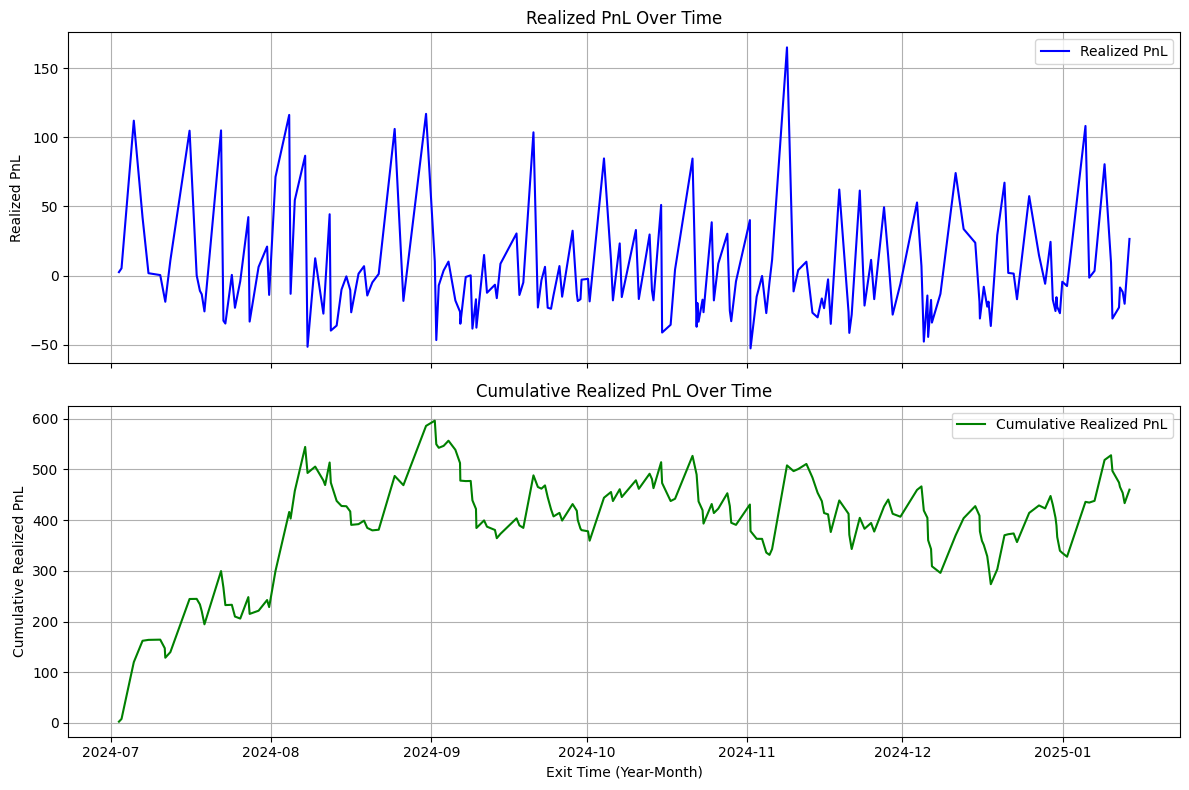

In [18]:
# Plot Cumullative pnl
plot_realized_pnl(backtest_trade_sim)

# Calculate Sharpe ratio

In [19]:
equity = backtest_trade_sim.copy()

equity = equity[['cumulative_realized_pnl']]

equity['cumulative_realized_pnl'] = equity['cumulative_realized_pnl'] + 10000

# Calculate daily strategy returns (percentage change in equity)
equity['strategy_returns'] = equity['cumulative_realized_pnl'].pct_change()

# Remove the NaN (first row, which has no previous row to compare)
equity.dropna(subset=['strategy_returns'], inplace=True)

# Risk-free rate (annualized 4.28% converted to daily for crypto, 365 days in a year)
risk_free_rate = 0.0428 / 365  # Daily risk-free rate for crypto market

# Continue with the same calculations
equity['excess_returns'] = equity['strategy_returns'] - risk_free_rate
average_excess_return = equity['excess_returns'].mean()
std_dev_excess_return = equity['excess_returns'].std()
sharpe_ratio = average_excess_return / std_dev_excess_return

# Print the Sharpe Ratio
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Optionally, to annualize the Sharpe Ratio (for crypto):
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(365)
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.2f}")


Sharpe Ratio: 0.04
Annualized Sharpe Ratio: 0.67


# Further Analysis

In [22]:
# Param Selection
position = 'long'
# position = 'short'

result = 'Win'
# result = 'Loss'

In [23]:
df_analysis = backtest_trade_sim[(backtest_trade_sim['position'] == position) & (backtest_trade_sim['win_loss'] == result)]
df_analysis = df_analysis[['open_time', 'open_price', 'exit_time', 'exit_price',
       'min_price', 'max_price', 'high_50', 'low_50', 'high_50_open_dif',
       'low_50_open_dif', 'bull', 'bull_50_count', 'chg_pct', 'chg_pct_50_sum',
       'abs_chg_pct', 'abs_chg_pct_50_sum', 'balance', 'open_fee', 'exit_fee',
       'realized_pnl', 'hold_time']]

,position,open_time,open_price,exit_time,exit_price,min_price,max_price,high_50,low_50,high_50_open_dif,...,open_fee,exit_fee,realized_pnl,hold_time,funding_fee_occurence,funding_fee,cumulative_realized_pnl,win_loss,is_loss,group
0,long,1719883800,147.307,1719932400,147.850,146.814,151.843,149.396,13.777687,1.418127,...,0.5,0.501843,2.584336,13.5,1.0,0.1,2.584336,Win,0,1
1,long,1719943200,149.906,1719975600,150.875,149.151,154.915,153.782,15.916205,2.585620,...,0.5,0.503232,5.360819,9.0,1.0,0.1,7.945155,Win,0,1
3,long,1720193400,133.631,1720326600,139.451,132.261,144.500,135.900,46.955577,1.697959,...,0.5,0.521776,42.130992,37.0,4.0,0.4,162.066495,Win,0,1
5,long,1720429200,140.452,1720621800,140.740,133.500,146.148,141.935,33.200282,1.055877,...,0.5,0.501025,0.449497,53.5,6.0,0.6,164.311849,Win,0,1
9,long,1720841400,139.161,1721111400,154.009,137.870,160.161,140.500,17.806538,0.962195,...,0.5,0.553348,104.743212,75.0,9.0,0.9,244.468490,Win,0,3
10,long,1721143800,157.798,1721230200,158.038,157.432,163.722,161.516,25.596527,2.356177,...,0.5,0.500760,0.220171,24.0,3.0,0.3,244.688661,Win,0,3
14,long,1721359800,160.090,1721637000,177.206,159.164,185.320,161.976,20.552766,1.178087,...,0.5,0.553457,104.961403,77.0,9.0,0.9,299.519908,Win,0,5
20,long,1721961000,174.906,1722092400,182.559,174.328,188.340,175.998,22.320432,0.624335,...,0.5,0.521877,42.333054,36.5,4.0,0.4,248.195065,Win,0,9
22,long,1722115800,186.100,1722263400,187.555,181.110,193.893,188.340,21.197623,1.203654,...,0.5,0.503909,6.314468,41.0,5.0,0.5,221.364754,Win,0,11
29,long,1722875400,135.121,1723041000,147.039,126.702,154.888,143.951,89.868888,6.534884,...,0.5,0.544101,86.658325,46.0,5.0,0.5,544.280368,Win,0,15


In [24]:
df_analysis.columns

Index(['position', 'open_time', 'open_price', 'exit_time', 'exit_price',
       'min_price', 'max_price', 'high_50', 'low_50', 'high_50_open_dif',
       'low_50_open_dif', 'bull', 'bull_50_count', 'chg_pct', 'chg_pct_50_sum',
       'abs_chg_pct', 'abs_chg_pct_50_sum', 'balance', 'open_fee', 'exit_fee',
       'realized_pnl', 'hold_time', 'funding_fee_occurence', 'funding_fee',
       'cumulative_realized_pnl', 'win_loss', 'is_loss', 'group'],
      dtype='object')